In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import numpy as np
import cartopy
import matplotlib
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use("ggplot")

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis()

Connection successful.


# CL Vestland: Summarise and visualise results

## 1. Combine outputs

Merge the two summary CSV generated by the two runs of notebook 03 (handling overlapping polygons).

In [3]:
# Read data
csv_path = r"../output/cl_vestland_results_summary_meqpm2pyr_1.csv"
df1 = pd.read_csv(csv_path)

csv_path = r"../output/cl_vestland_results_summary_meqpm2pyr_2.csv"
df2 = pd.read_csv(csv_path)

df = pd.concat([df1, df2], sort=False)

# Save combined
csv_path = r"../output/cl_vestland_results_summary_meqpm2pyr.csv"
df.to_csv(csv_path, index=False)

df.head()

,dataset,station_code,min,mean,max,std,count
0,fab_ex_n_2030bc_meqpm2pyr_50m,Sam_Stor,0.0,0.000000,0.000000,0.000000,2886
1,fab_ex_n_2030bc_meqpm2pyr_50m,Sam_Froe,0.0,0.000000,0.000000,0.000000,38648
2,fab_ex_n_2030bc_meqpm2pyr_50m,Sam_Frok,0.0,0.004824,1.043613,0.042899,50306
3,sswc_ex_2030bc_meqpm2pyr_50m,Sam_Stor,0.0,0.000000,0.000000,0.000000,2886
4,sswc_ex_2030bc_meqpm2pyr_50m,Sam_Froe,0.0,0.000000,0.000000,0.000000,38648


## 2. Get catchments

In [4]:
# Get outflows
sql = (
    "SELECT * FROM niva.stations "
    "WHERE station_id IN ( "
    "  SELECT station_id FROM niva.projects_stations "
    "  WHERE project_id IN ( "
    "    SELECT project_id FROM niva.projects "
    "    WHERE project_name = 'CL Vestland' "
    "    ) "
    "  ) "
)
stn_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
stn_gdf = stn_gdf.to_crs({"init": "epsg:25833"})

stn_gdf.head()

/home/jovyan/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,87,Sam_Froe,Samnanger_Frolandselva,None,5.798510,60.380058,POINT (-6218.205 6729188.752)
1,86,Sam_Stor,Samnanger_Storelva,None,5.798443,60.384011,POINT (-6160.286 6729626.599)
2,84,Sam_Tyss,Samnanger_Tysseelva,None,5.758580,60.374899,POINT (-8485.813 6728926.678)
3,85,Sam_Tyss_IntCat,Samnanger_Tysseelva_Intercatchment,None,5.758580,60.374899,POINT (-8485.813 6728926.678)
4,88,Sam_Frok,Samnanger_Frolandskanalen,None,5.793918,60.381434,POINT (-6448.257 6729376.408)


In [5]:
# Get catchments
stn_list = list(stn_gdf["station_id"].astype(str))
bind_pars = ",".join(stn_list)
sql = f"SELECT * FROM niva.catchments " f"WHERE station_id IN ({bind_pars})"
cat_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
cat_gdf = cat_gdf.to_crs({"init": "epsg:25833"})

# Join codes
cat_gdf = cat_gdf.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)
cat_gdf = cat_gdf[["station_id", "station_code", "geom"]]

cat_gdf.head()

/home/jovyan/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station_id,station_code,geom
0,84,Sam_Tyss,"MULTIPOLYGON (((547.072 6746299.978, 595.735 6..."
1,85,Sam_Tyss_IntCat,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3..."
2,86,Sam_Stor,"MULTIPOLYGON (((-4989.585 6733365.944, -5033.5..."
3,87,Sam_Froe,"MULTIPOLYGON (((2525.877 6733985.895, 2583.556..."
4,88,Sam_Frok,"MULTIPOLYGON (((2525.877 6733985.895, 2502.756..."


In [6]:
# Use small "intercatchment" for main watershed to avoid visualising overlap
df["station_code"].replace("Sam_Tyss", "Sam_Tyss_IntCat", inplace=True)

# Just need mean
df = df[["dataset", "station_code", "mean"]]

# Join chem to spatial data
gdf = cat_gdf.merge(df, on="station_code", how="right")

gdf

,station_id,station_code,geom,dataset,mean
0,85,Sam_Tyss_IntCat,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3...",fab_ex_n_2030bc_meqpm2pyr_50m,0.000000
1,85,Sam_Tyss_IntCat,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3...",sswc_ex_2030bc_meqpm2pyr_50m,0.000000
2,85,Sam_Tyss_IntCat,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3...",fab_ex_s_2030bc_meqpm2pyr_50m,0.000000
3,85,Sam_Tyss_IntCat,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3...",fab_ex_reg_id_1216_50m,2.449868
4,85,Sam_Tyss_IntCat,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3...",fab_ex_ns_2030bc_meqpm2pyr_50m,0.000000
...,...,...,...,...,...
91,88,Sam_Frok,"MULTIPOLYGON (((2525.877 6733985.895, 2502.756...",claoaa_meqpm2pyr_50m,30.957582
92,88,Sam_Frok,"MULTIPOLYGON (((2525.877 6733985.895, 2502.756...",clmaxnoaa_meqpm2pyr_50m,40.751521
93,88,Sam_Frok,"MULTIPOLYGON (((2525.877 6733985.895, 2502.756...",clminn_meqpm2pyr_50m,2.994526
94,88,Sam_Frok,"MULTIPOLYGON (((2525.877 6733985.895, 2502.756...",clmaxsoaa_meqpm2pyr_50m,31.290187


## 3. Create map

In [7]:
def plot_map_data(gdf, ax, title, buff=2000):
    gdf = gdf.copy()
    gdf['mean'] = gdf['mean'].round(0)
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    ax.set_extent([xmin - buff, xmax + buff, ymin - buff, ymax + buff], crs=crs)

    # Plot polygons
    gdf.plot(
        column="mean",
        edgecolor="none",
        cmap="coolwarm",
        alpha=0.5,
        legend=True,
        categorical=True,
        ax=ax,
        legend_kwds={'loc': 'lower right'}
    )
    
    # Plot outlines
    gdf.plot(
        facecolor="none",
        edgecolor="k",
        lw=2,
        ax=ax,
    )

    ax.add_wms(
        wms="https://openwms.statkart.no/skwms1/wms.topo4.graatone",
        layers=["topo4graatone_WMS"],
    )
    
    ax.set_title(title)

### 3.1. Critical loads

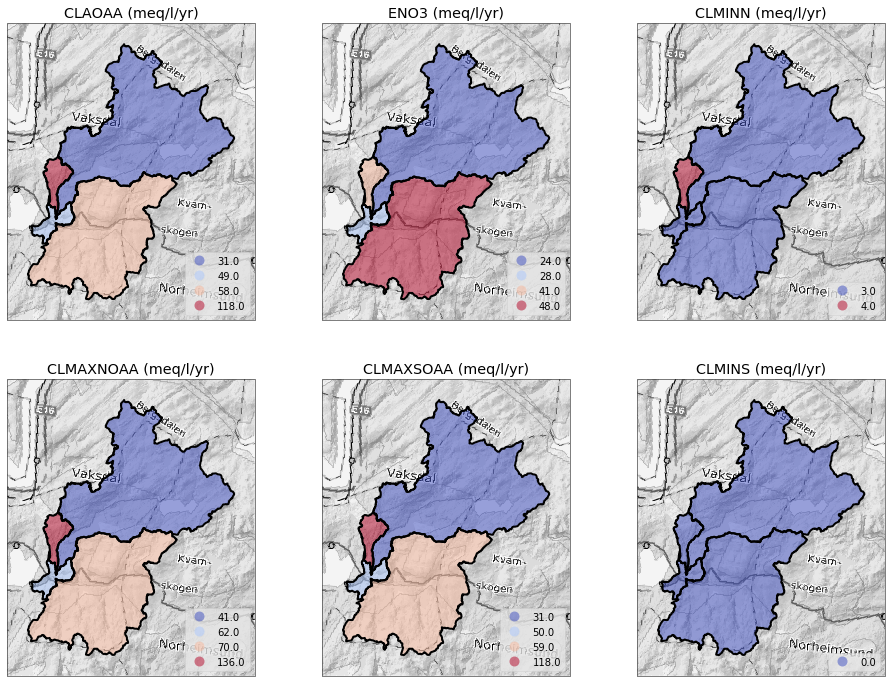

In [8]:
fig = plt.figure(figsize=(16, 12))

# Define co-ord system
crs = ccrs.UTM(33)

pars = ['claoaa', 'eno3', 'clminn', 'clmaxnoaa', 'clmaxsoaa', 'clmins']
for idx, par in enumerate(pars):
    ds_name = f'{par}_meqpm2pyr_50m'
    ds_gdf = gdf.query("dataset == @ds_name")
    ax = fig.add_subplot(2, 3, idx+1, projection=crs)
    plot_map_data(ds_gdf, ax, par.upper() + ' (meq/l/yr)')
    
png_path = r'../output/png/critical_loads_maps.png'
plt.savefig(png_path, dpi=200)

### 3.2. Deposition

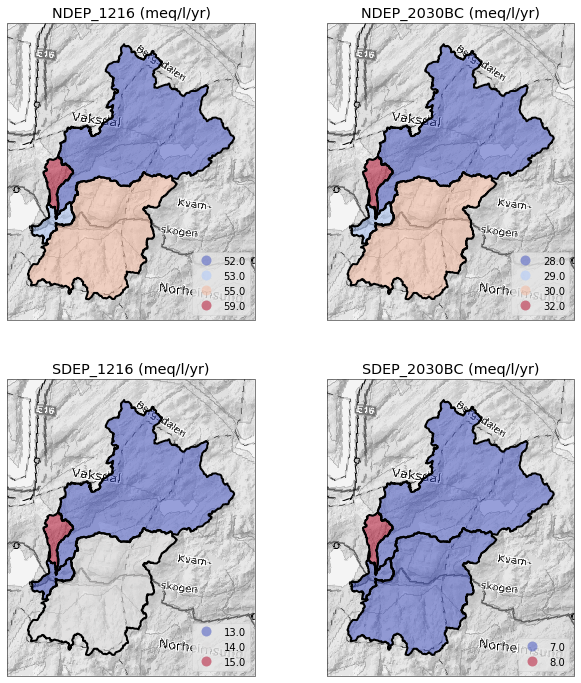

In [9]:
fig = plt.figure(figsize=(10.5, 12))

# Define co-ord system
crs = ccrs.UTM(33)

pars = ['ndep_1216', 'ndep_2030bc', 'sdep_1216', 'sdep_2030bc']
for idx, par in enumerate(pars):
    ds_name = f'{par}_meqpm2pyr_50m'
    ds_gdf = gdf.query("dataset == @ds_name")
    ax = fig.add_subplot(2, 2, idx+1, projection=crs)
    plot_map_data(ds_gdf, ax, par.upper() + ' (meq/l/yr)')
    
png_path = r'../output/png/deposition_maps.png'
plt.savefig(png_path, dpi=200)

### 3.3. Exceedance

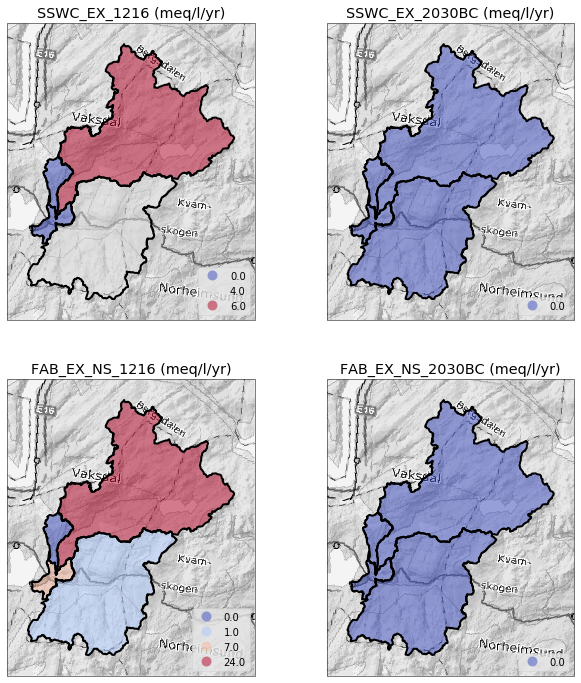

In [10]:
fig = plt.figure(figsize=(10.5, 12))

# Define co-ord system
crs = ccrs.UTM(33)

pars = ['sswc_ex_1216', 'sswc_ex_2030bc', 'fab_ex_ns_1216', 'fab_ex_ns_2030bc']
for idx, par in enumerate(pars):
    ds_name = f'{par}_meqpm2pyr_50m'
    ds_gdf = gdf.query("dataset == @ds_name")
    ax = fig.add_subplot(2, 2, idx+1, projection=crs)
    plot_map_data(ds_gdf, ax, par.upper() + ' (meq/l/yr)')
    
png_path = r'../output/png/exceedance_maps.png'
plt.savefig(png_path, dpi=200)